<a href="https://colab.research.google.com/github/lucas6028/machine_learning/blob/main/CNN/sports_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub

from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive


# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


## Use TensorFlow ImageDataGenerator for Image Loading and Augmentation

Use ImageDataGenerator to preprocess the images (e.g., rescale, rotate, flip) and create generators for training and validation data:

In [ ]:
train_dir = '/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/train'
test_dir = '/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/test'
val_dir = '/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/valid'

# Create ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Flow training images in batches from the dataset directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    suffle=False,
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


TypeError: ImageDataGenerator.flow_from_directory() got an unexpected keyword argument 'suffle'

## Define the CNN Model

In [ ]:
model = models.Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer with the number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,447,396 (169.55 MB)

 Trainable params: 44,447,396 (169.55 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Use early stopping to avoid overfitting.

In [ ]:
# Define early stopping
early_stopping = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    factor=0.5,
    verbose=0,
)

# Train the model
history = model.fit(
    train_generator,
    epochs=11,
    validation_data=validation_generator,
    callbacks=[early_stopping],
)

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 ━━━━━━━━━━━━━━━━━━━━ 182s 404ms/step - accuracy: 0.0635 - loss: 4.2718 - val_accuracy: 0.2180 - val_loss: 3.3085 - learning_rate: 0.0010
Epoch 2/11
422/422 ━━━━━━━━━━━━━━━━━━━━ 185s 380ms/step - accuracy: 0.2960 - loss: 2.8582 - val_accuracy: 0.3780 - val_loss: 2.5073 - learning_rate: 0.0010
Epoch 3/11
422/422 ━━━━━━━━━━━━━━━━━━━━ 159s 372ms/step - accuracy: 0.4027 - loss: 2.3230 - val_accuracy: 0.4420 - val_loss: 2.1852 - learning_rate: 0.0010
Epoch 4/11
422/422 ━━━━━━━━━━━━━━━━━━━━ 217s 409ms/step - accuracy: 0.4988 - loss: 1.9258 - val_accuracy: 0.4620 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 5/11
422/422 ━━━━━━━━━━━━━━━━━━━━ 189s 373ms/step - accuracy: 0.5499 - loss: 1.6639 - val_accuracy: 0.4320 - val_loss: 2.2371 - learning_rate: 0.0010
Epoch 6/11
422/422 ━━━━━━━━━━━━━━━━━━━━ 164s 384ms/step - accuracy: 0.6076 - loss: 1.4303 - val_accuracy: 0.4860 - val_loss: 2.0617 - learning_rate: 0.0010
Epoch 7/11
422/422 ━━━━━━━━━━━━━━━━━━━━ 164s 381ms/step - accuracy: 0.6548 

## Evaluate the model

Once trained, you can evaluate the model on a test set or use it for predictions.

In [ ]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4766 - loss: 1.9745 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4709 - loss: 2.4656
Validation Loss: 2.4435489177703857, Validation Accuracy: 0.49799999594688416


In [ ]:
# acc = history.history['acc']
# loss = history.history['loss']
val_acc=history.history['val_acc']
val_loss=history.history['val_loss']

epochs=range(100)

plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_acc,'b-',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

KeyError: 'val_acc'

In [ ]:
plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

NameError: name 'epochs' is not defined

## Store the model

In [ ]:
drive.mount('/content/drive')

# Save TensorFlow model to Google Drive
# model.save('/content/drive/MyDrive/model.h5')

Mounted at /content/drive


## Predicate on test data

In [17]:
# Make predictions
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

predictions = model.predict(test_generator)
predicted_classes_indices = np.argmax(predictions, axis=1)
predicted_class_names = [class_names[idx] for idx in predicted_classes_indices]

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


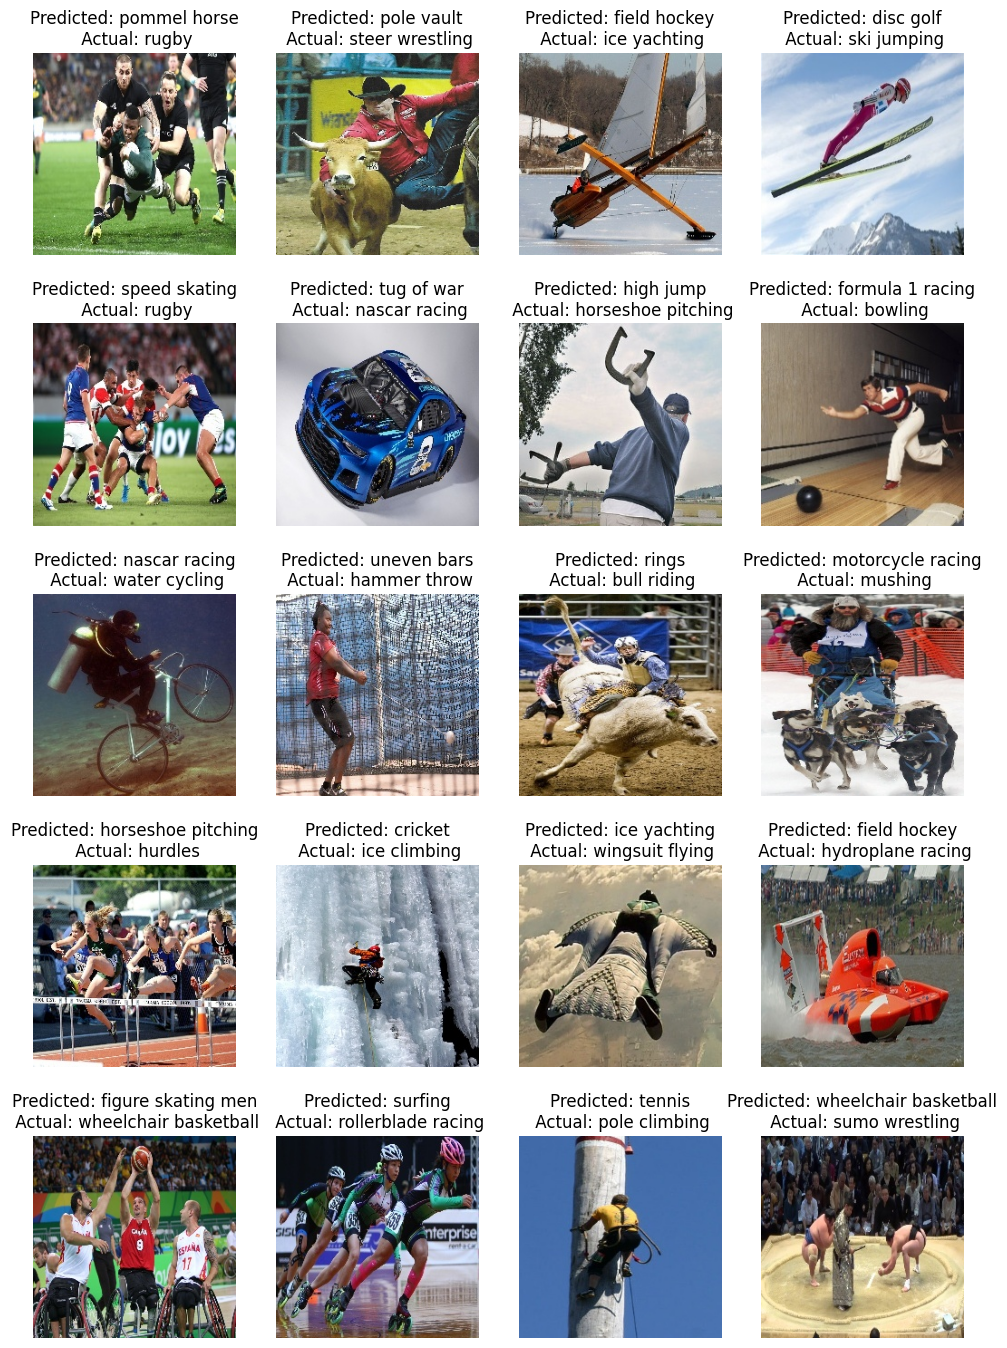

In [27]:
plt.figure(figsize=(12, 17))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(test_generator[0][0][i])
    actual_class_idx = np.argmax(test_generator[0][1][i])
    actual_class_name = class_names[actual_class_idx]
    plt.title(f"Predicted: {predicted_class_names[i]}\n Actual: {actual_class_name}")
    plt.axis('off')
plt.show()